In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler , LabelEncoder , OneHotEncoder
from sklearn.metrics import accuracy_score , confusion_matrix 
from sklearn.neural_network import MLPClassifier
import time
%matplotlib inline

In [28]:
cd /Users/sampathgubbala/Desktop/Data_Sets/sgemm_product_dataset

/Users/sampathgubbala/Desktop/Data_Sets/sgemm_product_dataset


In [32]:
df=pd.read_csv('sgemm_product.csv')

In [33]:
df["avg_run"] = df.iloc[:,14:].mean(axis = 1)

median_run = df['avg_run'].median()

df.loc[df['avg_run'] >= median_run, 'run_class'] = 1
df.loc[df['avg_run'] < median_run, 'run_class'] = 0

df.drop(['Run1 (ms)', 'Run2 (ms)','Run3 (ms)', 'Run4 (ms)', 'avg_run'], axis = 1, inplace = True)
df.head()

,MWG,NWG,KWG,MDIMC,NDIMC,MDIMA,NDIMB,KWI,VWM,VWN,STRM,STRN,SA,SB,run_class
0,16,16,16,8,8,8,8,2,1,1,0,0,0,0,1.0
1,16,16,16,8,8,8,8,2,1,1,0,0,0,1,1.0
2,16,16,16,8,8,8,8,2,1,1,0,0,1,0,1.0
3,16,16,16,8,8,8,8,2,1,1,0,0,1,1,1.0
4,16,16,16,8,8,8,8,2,1,1,0,1,0,0,1.0


In [35]:
# defining feature matrix(X) and response vector(y) 
dataset = df.iloc[0:10000, :]
X = dataset.iloc[0:10000, 0:14]
y = dataset["run_class"]
  
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X)

# K-Means 

### Using elblow method to find optimal number of clusters

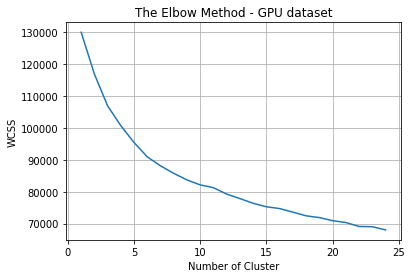

In [37]:
from sklearn.cluster import KMeans
wcss = []
for i in range (1,25):
    kmeans = KMeans(n_clusters=i , 
                    init = "k-means++" , 
                    max_iter= 500 , 
                    n_init= 10 , 
                    random_state= 0 )
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,25),wcss)
plt.grid()
plt.title("The Elbow Method - GPU dataset")
plt.xlabel("Number of Cluster")
plt.ylabel("WCSS")
plt.show()

# Applying k-means to gpu dataset

In [38]:
kmeans = KMeans(n_clusters= 10, 
                init = "k-means++" , 
                max_iter= 500 , 
                n_init= 10 , 
                random_state= 0)

y_kmeans_gpu = kmeans.fit_predict(X_train)

In [39]:
y_kmeans_gpu

array([2, 2, 2, ..., 6, 6, 6], dtype=int32)

# Implementing PCA for dataset to find maximum variance 

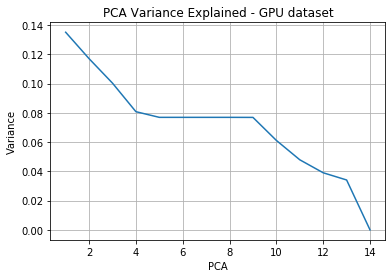

In [40]:
from sklearn.decomposition import PCA
pca = PCA(n_components= None)
X_gpu_PCA = pca.fit_transform(X_train)

explained_variance = pca.explained_variance_ratio_

plt.plot(range(1,15),explained_variance)
plt.title("PCA Variance Explained - GPU dataset")
plt.xlabel("PCA")
plt.ylabel("Variance")
plt.grid()
plt.show()

pca_final_gpu = PCA(n_components = 10 )
X_gpu_PCA = pca_final_gpu.fit_transform(X_train)

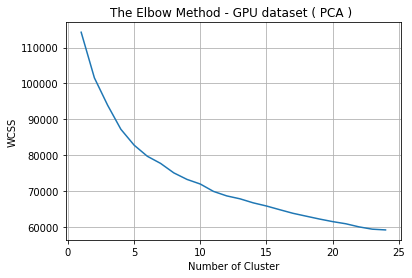

In [41]:
### Finding the number of clusters 
wcss_gpu_pca = []
for i in range (1,25):
    kmeans = KMeans(n_clusters=i , 
                    init = "k-means++" , 
                    max_iter= 500 , 
                    n_init= 10 , 
                    random_state= 0 )
    kmeans.fit(X_gpu_PCA)
    wcss_gpu_pca.append(kmeans.inertia_)

plt.plot(range(1,25),wcss_gpu_pca)
plt.title("The Elbow Method - GPU dataset ( PCA ) ")
plt.grid()
plt.xlabel("Number of Cluster")
plt.ylabel("WCSS")
plt.show()

In [42]:
# Applying k-means to GPU dataset
kmeans_pca_gpu_final = KMeans(n_clusters= 10, 
                init = "k-means++" , 
                max_iter= 500 , 
                n_init= 10 , 
                random_state= 0)

y_kmeans = kmeans_pca_gpu_final.fit_predict(X_gpu_PCA)


# Independent Component Analysis - ICA

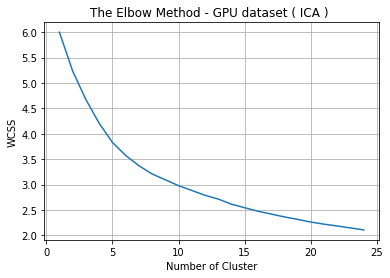

In [43]:
from sklearn.decomposition import FastICA

ica = FastICA(tol = 1e-2, max_iter = 1000, n_components =6)
X_gpu_ICA = ica.fit_transform(X_train)

wcss_gpu_ica = []
for i in range (1,25):
    kmeans = KMeans(n_clusters=i , 
                    init = "k-means++" , 
                    max_iter= 500 , 
                    n_init= 10 , 
                    random_state= 0 )
    kmeans.fit(X_gpu_ICA)
    wcss_gpu_ica.append(kmeans.inertia_)

plt.plot(range(1,25),wcss_gpu_ica)
plt.title("The Elbow Method - GPU dataset ( ICA ) ")
plt.grid()
plt.xlabel("Number of Cluster")
plt.ylabel("WCSS")
plt.show()

# Random Projection

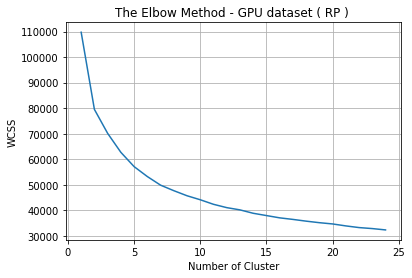

In [44]:
from sklearn.random_projection import SparseRandomProjection
srp = SparseRandomProjection(eps = 0.1, n_components = 7)
X_gpu_RP = srp.fit_transform(X_train)

wcss_gpu_ra = []
for i in range (1,25):
    kmeans = KMeans(n_clusters=i , 
                    init = "k-means++" , 
                    max_iter= 500 , 
                    n_init= 10 , 
                    random_state= 0 )
    kmeans.fit(X_gpu_RP)
    wcss_gpu_ra.append(kmeans.inertia_)

plt.plot(range(1,25),wcss_gpu_ra)
plt.title("The Elbow Method - GPU dataset ( RP ) ")
plt.grid()
plt.xlabel("Number of Cluster")
plt.ylabel("WCSS")
plt.show()

# Feature Selection - Decision Tree

In [25]:
# Using RFE to do the feature selection by Random Forest
from sklearn.feature_selection import RFECV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

dt = DecisionTreeClassifier(criterion = 'entropy', max_depth=6)
rfecv = RFECV(estimator=dt, step=1, cv=5, n_jobs=-1,
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % rfecv.n_features_)
print(rfecv.ranking_)

Optimal number of features : 7
[8 1 3 1 1 4 2 7 1 1 6 5 1 1]


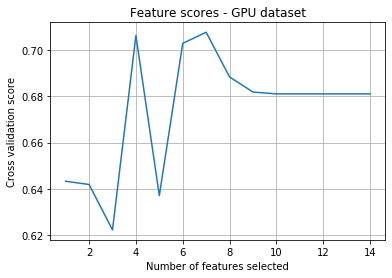

In [26]:
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.grid()
plt.title("Feature scores - GPU dataset")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

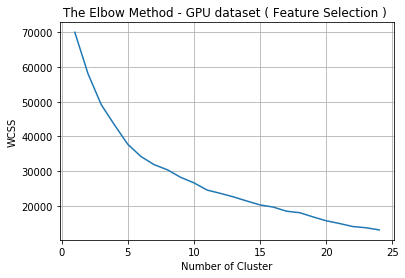

In [27]:
X_gpu_scaled_FS = X_train[:,(1,3,4,8,9,12,13)]

wcss_gpu_FS = []
for i in range (1,25):
    kmeans = KMeans(n_clusters=i , 
                    init = "k-means++" , 
                    max_iter= 500 , 
                    n_init= 10 , 
                    random_state= 0 )
    kmeans.fit(X_gpu_scaled_FS)
    wcss_gpu_FS.append(kmeans.inertia_)

plt.plot(range(1,25),wcss_gpu_FS)
plt.title("The Elbow Method - GPU dataset ( Feature Selection ) ")
plt.grid()
plt.xlabel("Number of Cluster")
plt.ylabel("WCSS")
plt.show()

# Expectation Maximization

In [15]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn import metrics
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

# Finding the number of clusters using Silhouette scores
n_clusters=np.arange(2, 10)
sils=[]
sils_err=[]
iterations=10
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(X_train) 
        labels=gmm.predict(X_train)
        sil=metrics.silhouette_score(X_train, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Text(0, 0.5, 'Score')

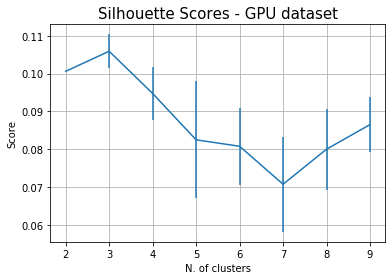

In [16]:
#Plotting the number of clusters using Silhouette
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores - GPU dataset", fontsize=15)
plt.grid()
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")


# Finding the number of clusters using Silhouette scores after implementing PCA

In [28]:
n_clusters=np.arange(2, 10)
sils_gpu_afterPCA=[]
sils_err_gpu_afterPCA=[]
iterations=10
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(X_gpu_PCA) 
        labels=gmm.predict(X_gpu_PCA)
        sil=metrics.silhouette_score(X_gpu_PCA, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils_gpu_afterPCA.append(val)
    sils_err_gpu_afterPCA.append(err)

Text(0, 0.5, 'Score')

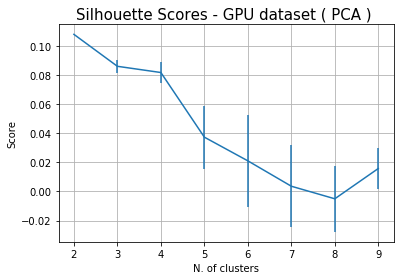

In [29]:
#Plotting the number of clusters using Silhouette
plt.errorbar(n_clusters, sils_gpu_afterPCA, yerr=sils_err_gpu_afterPCA)
plt.title("Silhouette Scores - GPU dataset ( PCA ) ", fontsize=15)
plt.grid()
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")


# EM with ICA

In [31]:
n_clusters=np.arange(2, 10)
sils_gpu_afterICA=[]
sils_err_gpu_afterICA=[]
iterations=10
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(X_gpu_ICA) 
        labels=gmm.predict(X_gpu_ICA)
        sil=metrics.silhouette_score(X_gpu_ICA, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils_gpu_afterICA.append(val)
    sils_err_gpu_afterICA.append(err)

Text(0, 0.5, 'Score')

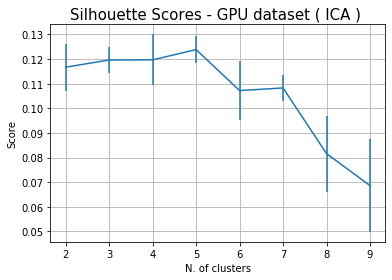

In [32]:
#Plotting the number of clusters using Silhouette
plt.errorbar(n_clusters, sils_gpu_afterICA, yerr=sils_err_gpu_afterICA)
plt.title("Silhouette Scores - GPU dataset ( ICA ) ", fontsize=15)
plt.grid()
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

# EM with Randomized Projections

Text(0, 0.5, 'Score')

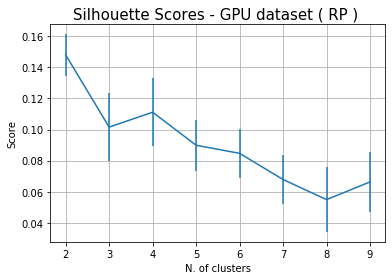

In [33]:
n_clusters=np.arange(2, 10)
sils_gpu_afterRP=[]
sils_err_gpu_afterRP=[]
iterations=10
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(X_gpu_RP) 
        labels=gmm.predict(X_gpu_RP)
        sil=metrics.silhouette_score(X_gpu_RP, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils_gpu_afterRP.append(val)
    sils_err_gpu_afterRP.append(err)

#Plotting the number of clusters using Silhouette
plt.errorbar(n_clusters, sils_gpu_afterRP, yerr=sils_err_gpu_afterRP)
plt.title("Silhouette Scores - GPU dataset ( RP ) ", fontsize=15)
plt.grid()
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")


# EM with Feature Selection

Text(0, 0.5, 'Score')

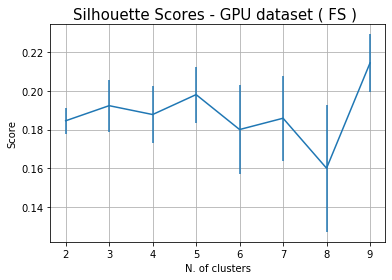

In [34]:
n_clusters=np.arange(2, 10)
sils_gpu_afterFS=[]
sils_err_gpu_afterFS=[]
iterations=10
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(X_gpu_scaled_FS) 
        labels=gmm.predict(X_gpu_scaled_FS)
        sil=metrics.silhouette_score(X_gpu_scaled_FS, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils_gpu_afterFS.append(val)
    sils_err_gpu_afterFS.append(err)

#Plotting the number of clusters using Silhouette
plt.errorbar(n_clusters, sils_gpu_afterFS, yerr=sils_err_gpu_afterFS)
plt.title("Silhouette Scores - GPU dataset ( FS ) ", fontsize=15)
plt.grid()
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

# ANN 

In [39]:
X_train_G ,X_test_G, y_train_G , y_test_G = train_test_split(X_train, 
                                                             y, 
                                                             test_size = 0.25 , 
                                                             random_state = 0)

### Original ANN 
ANN_class_Energy = MLPClassifier(hidden_layer_sizes= (10,10,10,10),
                          activation= 'relu' ,
                          solver= 'adam',max_iter = 1000,
                          random_state= 0 )

ANN_class_Energy.fit(X_train_G, y_train_G.ravel())

### predicting the test set result
y_pred_G = ANN_class_Energy.predict(X_test_G)
y_expect_G = y_test_G

### Finding the accuracy
Result_G = accuracy_score(y_expect_G , y_pred_G)
print(Result_G)

### create confusion matrix
cm_G = confusion_matrix(y_test_G , y_pred_G)
print(cm_G)

0.9532
[[1505   77]
 [  40  878]]


### ANN with PCA

In [41]:
X_train_E ,X_test_E, y_train_E , y_test_E = train_test_split(X_gpu_PCA, y, test_size = 0.25 , random_state = 0)

ANN_class_Energy = MLPClassifier(hidden_layer_sizes= (10,10,10,10),
                          activation= 'relu' ,
                          solver= 'adam',max_iter = 1000,
                          random_state= 0 )

ANN_class_Energy.fit(X_train_E, y_train_E.ravel())

### predicting the test set result
y_pred_E = ANN_class_Energy.predict(X_test_E)
y_expect_E = y_test_E

### Finding the accuracy
Result_E = accuracy_score(y_expect_E , y_pred_E)
print(Result_E)

### create confusion matrix
cm_E = confusion_matrix(y_test_E , y_pred_E)
print(cm_E)

0.93
[[1518   64]
 [ 111  807]]


### ANN with ICA

In [45]:
X_train_E ,X_test_E, y_train_E , y_test_E = train_test_split(X_gpu_ICA, y, test_size = 0.25 , random_state = 0)

ANN_class_Energy = MLPClassifier(hidden_layer_sizes= (10,10,10,10),
                          activation= 'relu' ,
                          solver= 'adam',max_iter = 1000,
                          random_state= 0 )

ANN_class_Energy.fit(X_train_E, y_train_E.ravel())

### predicting the test set result
y_pred_E = ANN_class_Energy.predict(X_test_E)
y_expect_E = y_test_E

### Finding the accuracy
Result_E = accuracy_score(y_expect_E , y_pred_E)
print(Result_E)

### create confusion matrix
cm_E = confusion_matrix(y_test_E , y_pred_E)
print(cm_E)

0.7904
[[1398  184]
 [ 340  578]]


### ANN with Randomized Projections

In [44]:
X_train_E ,X_test_E, y_train_E , y_test_E = train_test_split(X_gpu_RP, y, test_size = 0.25 , random_state = 0)

ANN_class_Energy = MLPClassifier(hidden_layer_sizes= (10,10,10,10),
                          activation= 'relu' ,
                          solver= 'adam',max_iter = 1000,
                          random_state= 0 )

ANN_class_Energy.fit(X_train_E, y_train_E.ravel())

### predicting the test set result
y_pred_E = ANN_class_Energy.predict(X_test_E)
y_expect_E = y_test_E

### Finding the accuracy
Result_E = accuracy_score(y_expect_E , y_pred_E)
print(Result_E)

### create confusion matrix
cm_E = confusion_matrix(y_test_E , y_pred_E)
print(cm_E)

0.8252
[[1333  249]
 [ 188  730]]


### ANN with Feature Selection 

In [46]:
X_train_E ,X_test_E, y_train_E , y_test_E = train_test_split(X_gpu_scaled_FS, y, test_size = 0.25 , random_state = 0)

ANN_class_Energy = MLPClassifier(hidden_layer_sizes= (10,10,10,10),
                          activation= 'relu' ,
                          solver= 'adam',max_iter = 1000,
                          random_state= 0 )

ANN_class_Energy.fit(X_train_E, y_train_E.ravel())

### predicting the test set result
y_pred_E = ANN_class_Energy.predict(X_test_E)
y_expect_E = y_test_E

### Finding the accuracy
Result_E = accuracy_score(y_expect_E , y_pred_E)
print(Result_E)

### create confusion matrix
cm_E = confusion_matrix(y_test_E , y_pred_E)
print(cm_E)

0.876
[[1472  110]
 [ 200  718]]


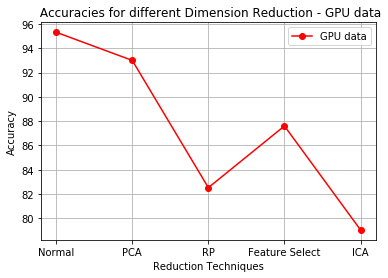

In [49]:
############## Plotting the accuracies 

accuracies_energy = [95.32 , 93 , 82.52 , 87.6 , 79.04]
accuracies_type = ['Normal','PCA','RP','Feature Select','ICA']
plt.plot(accuracies_type , accuracies_energy , marker='o',markersize=6,color='red',label='GPU data')
plt.title(" Accuracies for different Dimension Reduction - GPU data")
plt.xlabel("Reduction Techniques")
plt.grid()
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# RP vs ICA vs PCA PLOTS  

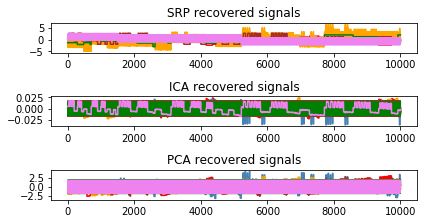

In [22]:
plt.figure()
models = [ X_gpu_RP,X_gpu_ICA, X_gpu_PCA]
names = ['SRP recovered signals',
        'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange', 'brown', 'green', 'violet']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

## ANN with cluster labels data

In [51]:
X_train_E ,X_test_E, y_train_E , y_test_E = train_test_split(y_kmeans_gpu, y, test_size = 0.25 , random_state = 0)

ANN_class_Energy = MLPClassifier(hidden_layer_sizes= (10,10,10,10),
                          activation= 'relu' ,
                          solver= 'adam',max_iter = 1000,
                          random_state= 0 )

ANN_class_Energy.fit(X_train_E.reshape(-1,1), y_train_E.ravel())

### predicting the test set result
y_pred_E = ANN_class_Energy.predict(X_test_E.reshape(-1,1))
y_expect_E = y_test_E

### Finding the accuracy
Result_E = accuracy_score(y_expect_E , y_pred_E)
print(Result_E)

### create confusion matrix
cm_E = confusion_matrix(y_test_E , y_pred_E)
print(cm_E)

0.6972
[[1502   80]
 [ 677  241]]
